In [1]:
import sys
import os
from torch.utils.data import DataLoader
sys.path.append("..")
from tqdm import tqdm
import shutil
import torch
import numpy as np
import pandas as pd

from utils import train_test_split, create_metadata_df, measurements_to_df, render_example_video_from_folder_name
from dataset_xy import CARLADatasetXY
from dataset import CARLADataset
from data_preprocessing import preprocessing, transform_lidar_bev

import json

from PIL import Image

/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_data = os.path.join("..", "..", "data", "data")
# path_data = "../../data/data/cycl_dataset_23_11/Routes_non-straight-junction-Scen4_Town07_junction_Seed2000/non-straight-junction-Scen4_Town07_junction_route74_11_24_00_29_14"
# path_data = os.path.join("..", "..", "data", "data", "rr_dataset_23_11")
#path_data = os.path.join("..", "..", "data", "data_prep_npy")

config_xy = {"used_inputs": ["rgb", "lidar_prep", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }

# Create df_meta 
df_meta_data = create_metadata_df(path_data, config_xy["used_inputs"])

# Create Dataset & DataLoader
dataset = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data, config=config_xy)

## Datset inspection

In [3]:
df_meta_data["dir"].str.extract("(Town[0-9][0-9])").value_counts(normalize=True)

Town04    0.235217
Town05    0.215354
Town03    0.159882
Town06    0.138998
Town07    0.087498
Town10    0.073697
Town01    0.048266
Town02    0.041087
dtype: float64

In [4]:
df_meta_data_town = df_meta_data["dir"].apply(lambda x: x.split(os.sep)[4]).to_frame("dir_first_level")
df_meta_data_town["town"] = df_meta_data["dir"].str.extract("(Town[0-9][0-9])")
df_meta_data_stats = df_meta_data_town.groupby("dir_first_level")["town"].value_counts(normalize=True).to_frame("freq").reset_index()

In [5]:
# with pd.option_context('display.max_rows', None,):
#     print(df_meta_data_stats)
df_meta_data_stats

,dir_first_level,town,freq
0,coke_dataset_23_11,Town05,0.319508
1,coke_dataset_23_11,Town04,0.280574
2,coke_dataset_23_11,Town06,0.125492
3,coke_dataset_23_11,Town03,0.080123
4,coke_dataset_23_11,Town02,0.061230
...,...,...,...
81,rl_dataset_23_11,Town03,0.083897
82,rl_dataset_23_11,Town10,0.078530
83,rr_dataset_23_11,Town06,0.515000
84,rr_dataset_23_11,Town04,0.415185


In [6]:
# Town that occur in every first level folder of the dataset --> Pick Town06 as Test Town (is 13% of entire data)
intersecting_towns = list(set.intersection(*df_meta_data_stats.groupby("dir_first_level")["town"].apply(lambda x: set(x)).tolist()))
intersecting_towns

['Town06', 'Town04', 'Town05']

In [7]:
# df_measurements = measurements_to_df(dataset)
df_measurements = pd.read_json("df_measurements.json")
df_measurements["dir_first_level"] = df_measurements["dir"].apply(lambda x: x.split(os.sep)[4])
# For later inspecting the train/test distributions
df_measurements["dir2"] = df_measurements["dir"].apply(lambda x: os.path.join(*x.split(os.sep)[:-2]))
df_measurements["brake"] = df_measurements["brake"].apply(lambda x: 1 if x else 0)

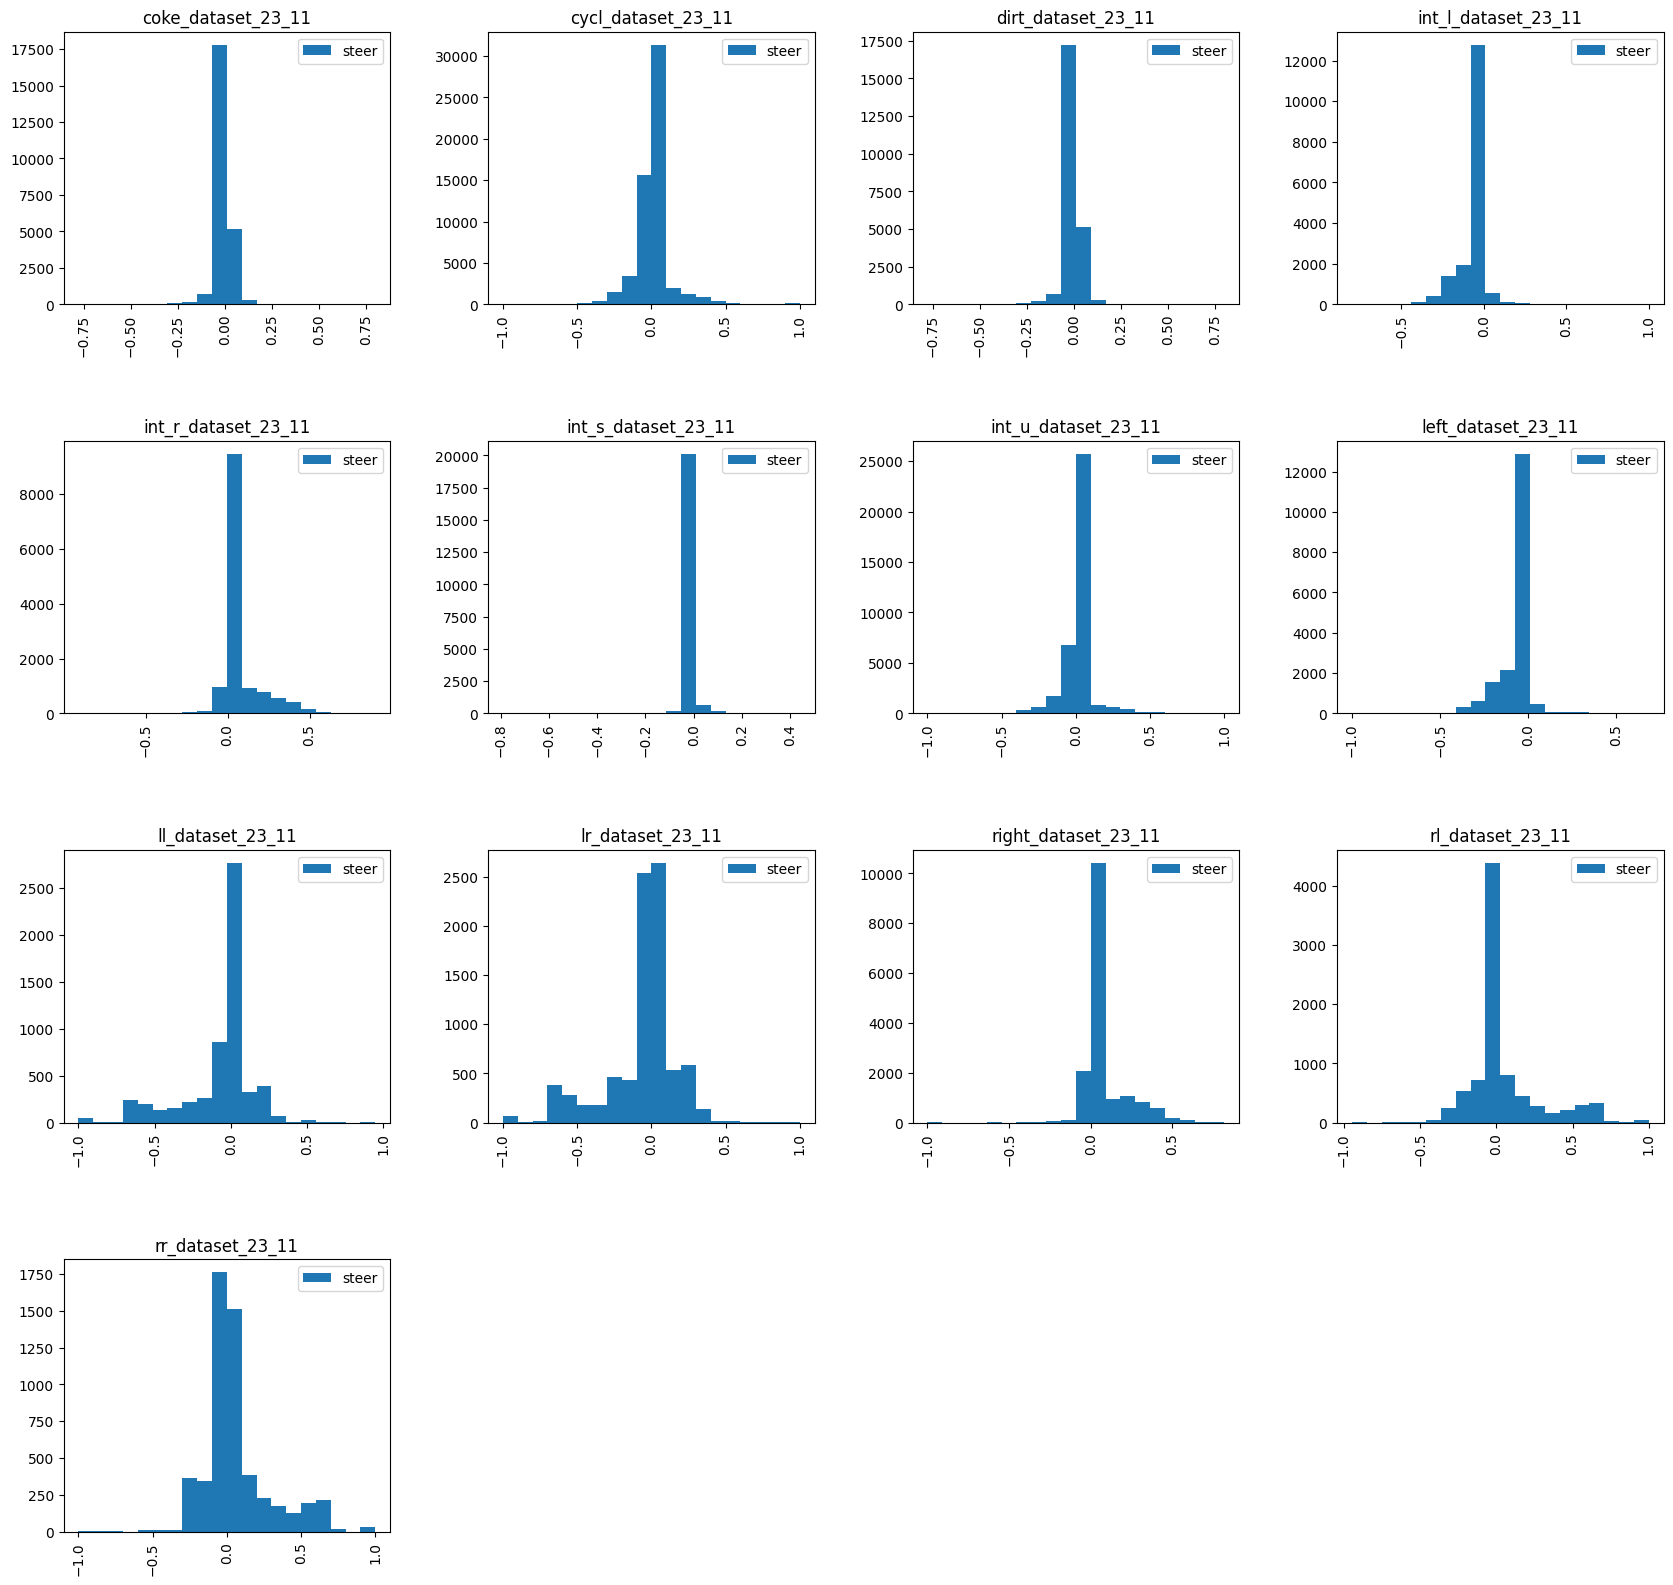

In [8]:
ax = df_measurements.hist(by="dir_first_level", column="steer", figsize=(20, 20), legend=True, bins=20)

In [9]:
def render_example_videos():
    # Content of videos don't really seem to fit the name of their corresponding location folder 
    # (e.g. in right_dataset almost no right turns ...) ... at least distribution-wise it seems plausible
    for folder in df_measurements["dir_first_level"].unique():
        path = os.path.join("..", "..", "data", "video", folder)
        if not os.path.exists(path):
            os.makedirs(path)
        for n in range(10):
            path_out = os.path.join(path, f"{folder}_{n}.mp4")
            render_example_video_from_folder_name(df_meta_data, folder="int_u_dataset_23_11", path_out=path_out)

## Implement Approach 1 as described in Issue 122

In [17]:
# Now try with capsulated function from utils
train_test_config = {
    "train": ['Town00', 'Town01', 'Town02', 'Town03', 'Town04', 'Town05', 'Town07', 'Town08', 'Town09', 'Town10'],
    "test": ['Town06']
}

df_train, df_test_1, df_test_2 = train_test_split(df_meta_data, towns_intersect=train_test_config)

In [28]:
total = len(df_train) + len(df_test_1) + len(df_test_2)

In [31]:
len(df_test_2) / total

0.13899836177052424

## Check distributions of Approach 1

In test2 we have a little less brake (and thus a little more higher speed) than in the others but still fine

In [248]:
df_measurements_train = df_measurements[df_measurements["dir2"].isin(df_meta_data_routes_train["dir"])]
df_measurements_test_1 = df_measurements[df_measurements["dir2"].isin(df_meta_data_routes_test_1["dir"])]
df_measurements_test_2 = df_measurements[df_measurements["dir2"].isin(df_meta_data_routes_test_2["dir"])]

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>],
       [<AxesSubplot: title={'center': 'brake'}>, <AxesSubplot: >]],
      dtype=object)

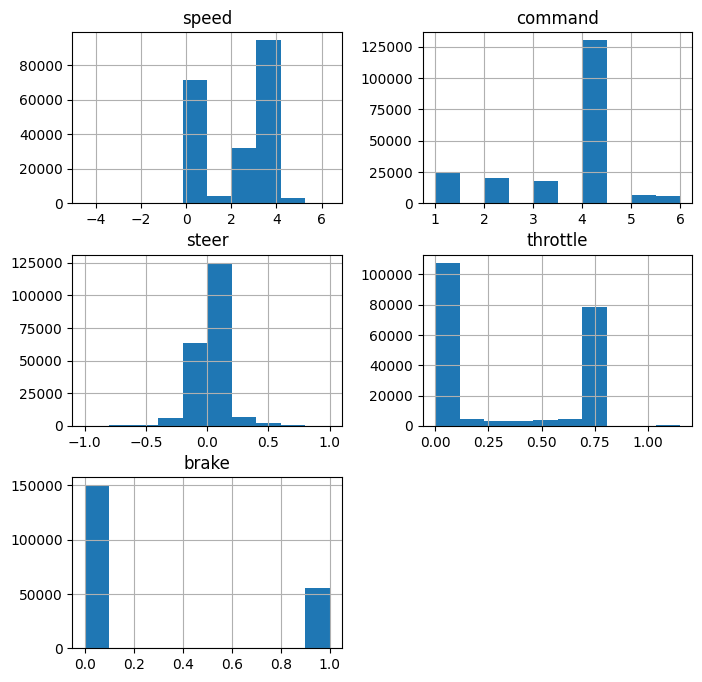

In [253]:
df_measurements_train.hist(figsize=(8, 8))

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>],
       [<AxesSubplot: title={'center': 'brake'}>, <AxesSubplot: >]],
      dtype=object)

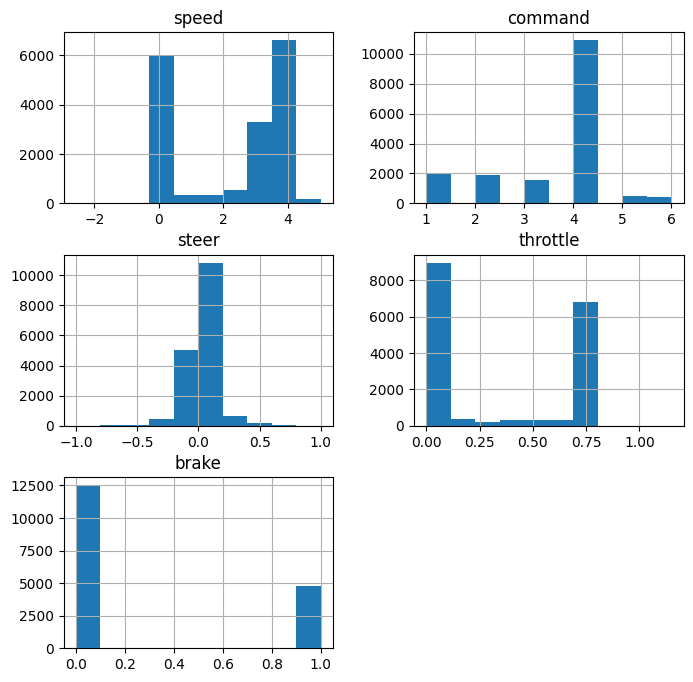

In [254]:
df_measurements_test_1.hist(figsize=(8, 8))

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>],
       [<AxesSubplot: title={'center': 'brake'}>, <AxesSubplot: >]],
      dtype=object)

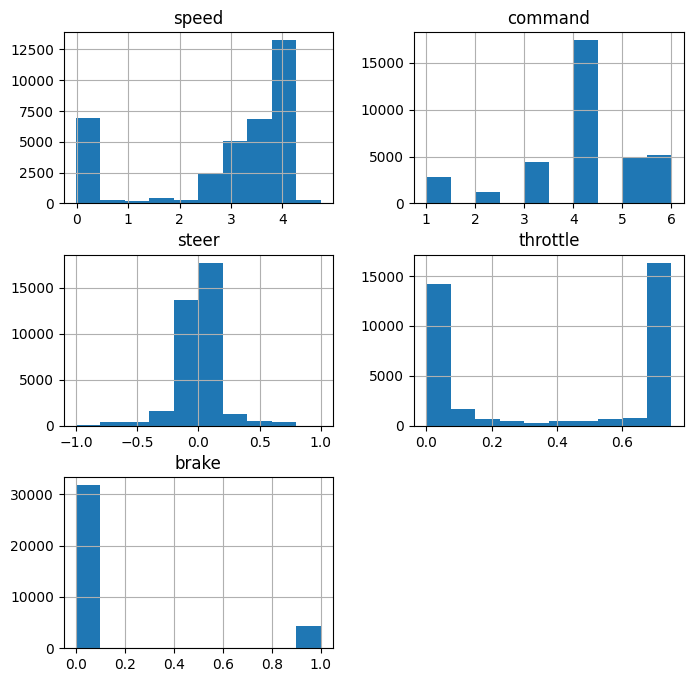

In [255]:
df_measurements_test_2.hist(figsize=(8, 8))